In [8642]:
import sys
import importlib
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad


In [8643]:
sys.path.append('..')  # Go up one directory to where utils.py is located
import utils  # Ensure you import the module itself, not specific items
importlib.reload(utils)  # Reload the module to apply updates
from utils import *

Consider the simple harmonic oscillator $x:\mathbb{R}^+ \to \mathbb{R}$ given by:
$$ \begin{cases}
\frac{d^2x}{dt^2} &= -\omega^2 x \\
x(0) &= q_0 \\
\frac{dx}{dt}|_{t=0}& = p_0.
\end{cases},
$$
which can be reformulated as a system of differential equations
$$ 
\begin{cases}
\frac{dx}{dt} = y \\
\frac{dy}{dt} = -\omega^2 x  \\
x(0) = q_0 \\
y(0) = p_0,
\end{cases}
$$
where we defined $y:= \frac{dx}{dt}$. Our goal is to implement a simple DeepONet to approximate a solution for this BVP.

The analytical solution of the BVP is 
$$
\begin{cases}
x(t) = q_0 \cos(\omega t) + \frac{p_0}{\omega}\sin(\omega t)\\
y(t) = p_0 \cos(\omega t) - q_0 \omega \sin(\omega t).
\end{cases}
$$

In [8644]:
# Get analytical solution of the BVP for given q0, p0 and t
def analytic_solution(bv, t, w=1):
    q0 = bv[:,None,0] 
    p0 = bv[:,None,1] 
    x = torch.tensor(q0 @ np.cos(w * t).T + (p0 @ np.sin(w * t).T) / w)
    y = torch.tensor(p0 @ np.cos(w * t).T - (q0 @ np.sin(w * t).T) * w)
    return torch.stack((x, y), dim=2)

In [8645]:
def PI_loss_fn(u, t, w=1):

    x, y = u[...,0], u[...,1]
    
    ones = torch.ones_like(u[0,:,0])
    
    x_t = torch.stack([grad(xi.T, t, grad_outputs=ones, create_graph=True)[0].squeeze(-1) for xi in x])
    y_t = torch.stack([grad(yi.T, t, grad_outputs=ones, create_graph=True)[0].squeeze(-1) for yi in y])

    return torch.stack((x_t - y, y_t + (w**2)*x))    

In [8646]:
T = 0.01
bv_ = np.random.uniform(low=-1, high=1, size=(3, 2)).astype(np.float32)
t = np.random.uniform(low=0, high=T, size=(10, 1)).astype(np.float32)

Px = (bv_, t)

In [8647]:
bv = np.random.uniform(low=-1, high=1, size=(10, 2)).astype(np.float32)

#grid_points = torch.linspace(-1, 1, 10, dtype=torch.float32)
#bv = torch.cartesian_prod(grid_points, grid_points).detach().clone().numpy()

#t = np.random.uniform(low=0, high=T, size=(20, 1)).astype(np.float32)
t = np.array([0.01])[:,None].astype(np.float32)

#t = np.linspace(0, T, 10).astype(np.float32)[:,None]

y_train = analytic_solution(bv, t)
X_train = (bv, t)


In [8648]:
bv = np.random.uniform(low=-1, high=1, size=(100, 2)).astype(np.float32)
#t = np.random.uniform(low=0, high=T, size=(10, 1)).astype(np.float32)
#t = np.linspace(0, T, 10).astype(np.float32)[:,None]

t = np.array([0.01])[:,None].astype(np.float32)

y_test = analytic_solution(bv, t)
X_test = (bv, t)


In [8649]:
num_pts = 25
grid_points = torch.linspace(-1, 1, num_pts, requires_grad=False, dtype=torch.float32)
mesh = torch.cartesian_prod(grid_points, grid_points)

X_col = (mesh, t)

In [8650]:
net = DeepONet([40, 40, 40], [40, 40, 40], dim=2, K=1, activation='tanh', conserve_energy=False, symplectic=3, reg=False)
model = Model(X_train, y_train, X_test, y_test, X_col, net, Px=None, PI_loss_fn=None, Tmax=5)
model.train(iterations=10_000)

Step 	 Train loss 	 Test loss
1000 	 [5.72e-06] 	 [1.72e-05] 	 New best model!
2000 	 [5.66e-06] 	 [1.71e-05] 	 New best model!
3000 	 [5.63e-06] 	 [1.71e-05] 	 New best model!
4000 	 [5.61e-06] 	 [1.70e-05] 	 New best model!
5000 	 [5.61e-06] 	 [1.70e-05] 	 New best model!
6000 	 [5.61e-06] 	 [1.70e-05] 	 
7000 	 [5.61e-06] 	 [1.70e-05] 	 
8000 	 [5.71e-06] 	 [1.71e-05] 	 
9000 	 [5.70e-06] 	 [1.71e-05] 	 
10000 	 [5.69e-06] 	 [1.71e-05] 	 


In [8651]:
def test_symplecticity(T, num_pts=100):

        J = torch.tensor([[0, 1], [-1, 0]], dtype=torch.float32)[None,...]
        #norm_J = torch.linalg.norm(J)
        
        grid_points = torch.linspace(-1, 1, num_pts, requires_grad=True, dtype=torch.float32)
        mesh = torch.cartesian_prod(grid_points, grid_points)
        #print(mesh)
        
        t = torch.tensor([T], requires_grad=True, dtype=torch.float32).reshape(-1, 1)
        
        #t = torch.linspace(0, 10, 10, dtype=torch.float32)[:,None]
        
        #k = 5
        

        
        
        N = model.net(mesh, t)[:,0,:]
        
        
        
                
        #N_0 = model.net(mesh, torch.zeros_like(t))
        #N = N * mesh[:,None,:] / N_0
        
        
        row1 = grad(N[:,0], mesh, grad_outputs=torch.ones_like(N[:,0]), retain_graph=True)[0]
        row2 = grad(N[:,1], mesh, grad_outputs=torch.ones_like(N[:,1]), retain_graph=True)[0]
        
        
        
        #row1 = grad(N1, bv, retain_graph=True)[0].squeeze()
        #row2 = grad(N2, bv, retain_graph=True)[0].squeeze()
        #Jac = torch.stack((row1, row2))
        #det = row1[0]*row2[1] - row1[1]*row2[0]
        #print(Jac)
        D = torch.stack((row1, row2), axis=-1)
        
        
        
        #delta_J.append(np.linalg.norm(Jac.T @ J @ Jac -J))
        
        
        
        I = torch.tensor([[1, 0], [0, 1]], dtype=torch.float64)
        
        
        
        
        
        
        det = row1[:,0]*row2[:,1] - row1[:,1]*row2[:,0]  
      
                
        det = det.numpy().reshape(num_pts, num_pts)
        plt.figure(figsize=(8, 6))
        plt.imshow(det, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
        plt.colorbar(label='$\Delta J$')
        plt.title("$\Delta J = || \\nabla \mathcal{N}(t)^T J \\nabla \mathcal{N}(t) - J||/||J||$ over $(q,p)$-grid, for t=" + f"{T}")
        plt.xlabel('q')
        plt.ylabel('p')
        plt.show()

In [8652]:
# test_symplecticity(T=0, num_pts=50)
# test_symplecticity(T=0.5, num_pts=50)
# test_symplecticity(T=1, num_pts=50)

In [8653]:
def plot_energy(q0, p0, dpi=100):
        
    # Energy test boundary values
    #energy_bv =  torch.tensor([[q0, p0]], dtype=torch.float32).requires_grad_(True)
    
    # Energy test time-domain
    #energy_t = torch.linspace(0, 5, 100, requires_grad=True).reshape(-1, 1).requires_grad_(True)
    
    
    

    #til_Thalf = np.linspace(0, T/2, 50).reshape(-1, 1)
    #Thalf = np.array([T/2]).reshape(-1, 1)

    #t_full = np.linspace(0, T, 100).reshape(-1, 1)

    bv = np.array([[q0, p0]], dtype=np.float32)
    
    t_full = np.linspace(0, 0.01, 20).reshape(-1, 1)

    #ground_truth = analytic_solution(bv, t_full)

    #pred_first_half  = model.predict(bv, til_Thalf)
    #pred_second_half = model.predict(model.predict(bv, Thalf)[:,0,:], til_Thalf)

    #u = torch.concatenate((pred_first_half, pred_second_half), axis=1)
    
    
    
    u = model.predict(bv, t_full)
    
    
    
    
    # Calculate total energy
    #u = model.net(energy_bv, energy_t)   
    x, y = u[..., 0], u[..., 1]        
    E = (x**2 + y**2)/2
            
    _, ax = plt.subplots(figsize=(8, 2), dpi=dpi)
    
    ax.set_title(f'Total Energy of DeepONet Prediction $(q_0, p_0)$=({q0}, {p0})')
    ax.plot(t_full, np.ones_like(t_full)*(q0**2 + p0**2)/2, alpha=0.5, linewidth=5, label='True energy')
    ax.plot(t_full, E[0,...].detach(), '--', alpha=0.8, linewidth=3,  label='DeepONet energy')
    ax.legend()
    ax.grid(True)
    
    ax.set_xlabel("t")
    ax.set_ylabel("Total energy")
    plt.show()

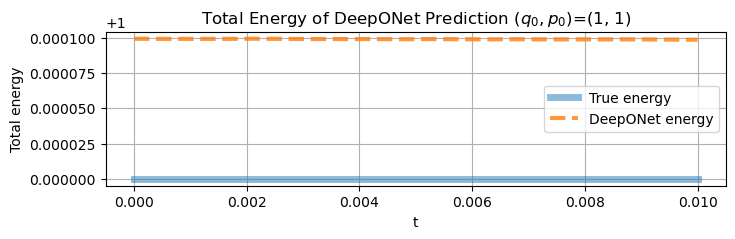

In [8654]:
plot_energy(q0=1, p0=1)

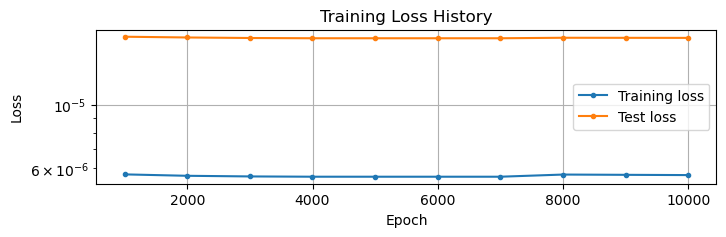

In [8655]:
model.plot_losshistory()

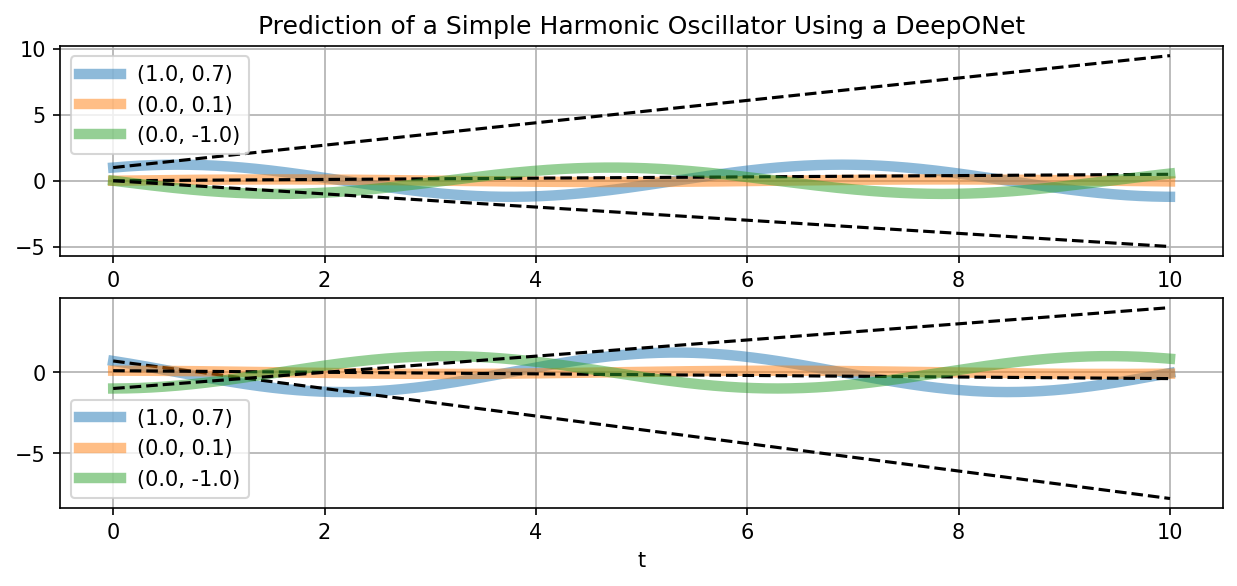

In [8656]:
# Plot model prediction for one omega

# Get model prediction
iters = 1000
h = 0.01
T = h * iters

h = torch.tensor([[h]], dtype=torch.float32)


conj_momenta = np.array([[1, 0.7], [0, 0.1], [0,-1]]).astype(np.float32)

bv = np.array([[1, 0.7], [0, 0.1], [0,-1]]).astype(np.float32)

t_curr = 0

for i in range(iters+1):
    
    
    if i == 0:
        pred = torch.tensor(conj_momenta, dtype=torch.float32)[:, None, :]
        
    
        
    
    else:
        pred = torch.concatenate((pred, conj_momenta[:,None,:].detach()), axis=1)
        
        
    conj_momenta = model.predict(conj_momenta, h).squeeze(1)
    
    
    
    



# til_Thalf = np.linspace(0, T/2, 50).reshape(-1, 1)
# Thalf = np.array([T/2]).reshape(-1, 1)

t_full = np.linspace(0, T, iters+1).reshape(-1, 1)




# bv = np.array([[0.5, 0.7], [0, 0.1], [0,-1]]).astype(np.float32)



#pred  = model.predict(bv, t_full)




ground_truth = analytic_solution(bv, t_full)


# pred_first_half  = model.predict(bv, til_Thalf)
# pred_second_half = model.predict(model.predict(bv, Thalf)[:,0,:], til_Thalf)

# pred = torch.concatenate((pred_first_half, pred_second_half), axis=1)




# Plot prediction vs. solution
fig, axes = plt.subplots(2, 1, figsize=(10, 4), dpi=150)

axes[0].set_title('Prediction of a Simple Harmonic Oscillator Using a DeepONet')

for k, ax in enumerate(axes.flat):
    for l in range(pred.shape[0]):
        label = '({:.1f}, {:.1f})'.format(bv[l,0], bv[l,1])
        ax.plot(t_full.flatten(), ground_truth[l,:,k], label=label, alpha=0.5, linewidth=5)
        
        ax.plot(t_full.flatten(), pred[l,:,k].tolist(), '--', c='k')

    ax.legend()
    ax.grid(True)
ax.set_xlabel("t")
plt.show()

In [8657]:
# # Plot model prediction for one omega

# # Get model prediction

# t = np.zeros((1,1))

# num_pts = 10
# grid_points = torch.linspace(-1, 1, num_pts, requires_grad=False, dtype=torch.float32)
# mesh = torch.cartesian_prod(grid_points, grid_points)

# ground_truth = analytic_solution(mesh, t)

# pred = model.predict(mesh, t)




# q_pred = pred[:,0,0].reshape(num_pts, num_pts).detach()
# p_pred = pred[:,0,1].reshape(num_pts, num_pts).detach()




# q = ground_truth[:,0,0].reshape(num_pts, num_pts).detach()
# p = ground_truth[:,0,1].reshape(num_pts, num_pts).detach()


# plt.figure(figsize=(8, 6))
# plt.imshow(torch.abs(q_pred-q), extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
# plt.colorbar(label='label')
# plt.title("Title")
# plt.xlabel('q')
# plt.ylabel('p')
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.imshow(torch.abs(p_pred-p), extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
# plt.colorbar(label='label')
# plt.title("Title")
# plt.xlabel('q')
# plt.ylabel('p')
# plt.show()

In [8658]:
# class M():
    
#     def __init__(
#         self, x_train, y_train, x_test, y_test, net, optimizer='adam', lr=0.001):     
        
#         # Training data
#         self.x_train = x_train
#         self.y_train = y_train
        
#         # Testing data
#         self.x_test = x_test
#         self.y_test = y_test

        
#         # Network
#         self.net = net
        
#         # Loss history
#         self.tlosshistory = []  # training loss
#         self.vlosshistory = []  # validation/test loss

#         # Initialize optimizer (default adam)
#         optimizer = {'adam':torch.optim.Adam, 'sgd':torch.optim.SGD}[optimizer]
#         self.optimizer = optimizer(net.parameters(), lr=lr)
        
#         # Set loss function (MSE default)
#         self.mse = torch.nn.MSELoss()
        
#         self.loss_fn = self.MSE_loss 
                
        
#     # Format data as torch tensor with dtype=float32    
#     def format(self, x, requires_grad=False):
#         x = x if isinstance(x, torch.Tensor) else torch.tensor(x)
#         return x.to(torch.float32).requires_grad_(requires_grad)
    
#     def MSE_loss(self, prediction, targets):
#         return self.mse(prediction, targets)
        
        
#     # Train network
#     def train(self, iterations):
        
#         # Train step history
#         self.steps = []
        
#         # Set net to train mode
#         self.net.train(True)
        
#         # Training process updates
#         print('Step \t Train loss \t Test loss')

#         for iter in range(iterations):
            
            
#             # Train
#             self.optimizer.zero_grad()
#             prediction = self.net(self.x_train)
            
            
#             loss = self.loss_fn(prediction, self.y_train)
            
            
#             loss.backward(retain_graph=True)
#             self.optimizer.step()
#             tloss = loss.item()

#             # Test
#             if iter % 1000 == 999:
#                 # Set net to evalutation mode
#                 self.net.eval()
                
#                 # Don't calculate gradients
#                 with torch.no_grad():
                
#                     outputs = self.net(self.x_test)  
#                     vloss = self.loss_fn(outputs, self.y_test).item()
                    
    
#                 # Save loss history
#                 self.vlosshistory.append(vloss)
#                 self.tlosshistory.append(tloss)
#                 self.steps.append(iter)
#                 self.net.train(True)
                
#                 print('{} \t [{:.2e}] \t [{:.2e}]'.format(iter + 1, tloss, vloss))    
                
                
                        
            
            
#     def plot_losshistory(self, dpi=100):
#         # Plot the loss trajectory
#         _, ax = plt.subplots(figsize=(8, 2), dpi=dpi)
#         ax.plot(self.steps, self.tlosshistory, '.-', label='Training loss')
#         ax.plot(self.steps, self.vlosshistory, '.-', label='Test loss')
#         ax.set_title("Training Loss History")
#         ax.set_xlabel("Epoch")
#         ax.set_ylabel("Loss")
#         ax.set_yscale('log')
#         ax.grid(True)
#         ax.legend()
#         plt.show()
        
                
        

In [8659]:
# bv = -2 * torch.rand(50, 2, dtype=torch.float32) + 1
# t = torch.linspace(0, T, 100, dtype=torch.float32)[:,None]

# x_train = model.predict(bv, t)
# #x_train = bv
# y_train = torch.linalg.norm(x_train, dim=-1, keepdim=True)

# bv = -2 * torch.rand(10, 2, dtype=torch.float32) + 1
# t = torch.linspace(0, T, 100, dtype=torch.float32)[:,None]

# x_test = model.predict(bv, t)
# y_test = torch.linalg.norm(x_test, dim=-1, keepdim=True)





# H = FNN([2, 40, 40, 40, 1])

# m = M(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, net=H)
# m.train(10_000)


In [8660]:
# # Plot model prediction for one omega

# # Get model prediction

# t = np.zeros((1,1))

# num_pts = 50
# grid_points = torch.linspace(-1, 1, num_pts, requires_grad=False, dtype=torch.float32)
# mesh = torch.cartesian_prod(grid_points, grid_points)

# H_true = torch.linalg.norm(mesh, dim=-1, keepdim=True).reshape(num_pts, num_pts).detach()

# pred = H(mesh).reshape(num_pts, num_pts).detach()






# fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# # First subplot: Heatmap
# heatmap = axes[0].imshow(np.abs(pred.numpy() - H_true.numpy()), extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
# axes[0].set_title("Heatmap of Prediction")
# axes[0].set_xlabel('q')
# axes[0].set_ylabel('p')

# # Add colorbar for the heatmap
# plt.colorbar(heatmap, ax=axes[0], label='Prediction')

# # Second subplot: Surface plot
# ax = fig.add_subplot(122, projection='3d')

# # Create the 2D grid
# X, Y = torch.meshgrid(grid_points, grid_points)
# X = X.numpy()  # Convert torch tensor to numpy for plotting
# Y = Y.numpy()  # Convert torch tensor to numpy for plotting
# Z = pred.numpy()  # Predicted values (also as numpy)

# # Plot the surface
# surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# # Add color bar and labels
# fig.colorbar(surf, ax=ax, label='Prediction')
# ax.set_title("3D Surface Plot")
# ax.set_xlabel('q')
# ax.set_ylabel('p')
# ax.set_zlabel('H')

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()

In [8661]:
A = np.array([[1, 0, 0, 0], [0, 0, 1, 0], [0, -1, 0, 0], [0, 0, 0, 1]])
J = np.array([[0, 0, 0, -1], [0, 0, -1, 0], [0, 1, 0, 0], [1, 0, 0, 0]])

print(A)
print(J.T @ J)
print(J @ J)

[[ 1  0  0  0]
 [ 0  0  1  0]
 [ 0 -1  0  0]
 [ 0  0  0  1]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
[[-1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0 -1]]
